In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
EXAMPLE_FILE='SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
SPAM_CAT=1
HAM_CAT=0
DATA_JSON_FILE='SpamData/01_Processing/email_text_data.json'
WHALE_FILE='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
skull_icon='SpamData/01_Processing/wordcloud_resources/skull-icon.png'
VOCAB_SIZE=2500
WORD_ID_FILE='SpamData/01_Processing/wordcloud_resources/word_id.csv'


TRAINING_DATA_FILE='SpamData/02_Training/train-data.txt'
TEST_DATA_FILE='SpamData/02_Training/test-data.txt'

In [3]:
stream=open(EXAMPLE_FILE,encoding='latin-1')

In [4]:
message=stream.read()
stream.close()

In [5]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if line=='\n':
        is_body=True
    elif is_body:
        lines.append(line)
stream.close()
email_body='\n'.join(lines)

In [6]:
print(email_body)

Dear Mr Still

Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.

Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Letters b

### GENERATOR FUNCTIONS - EMAIL BODY EXTRACTION

In [7]:
def email_body_generator(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            filepath=join(root,file_name)
            stream=open(filepath,encoding='latin-1')
            lines=[]
            is_body=False
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True
            stream.close()
            email_body='\n'.join(lines)
            yield file_name,email_body

In [8]:
def df_from_directory(path,classification):
    rows=[]
    row_names=[]
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,  index=row_names)

In [9]:
spam_emails=df_from_directory(SPAM_1_PATH,1)
spam_emails=spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [10]:
spam_emails.shape

(1898, 2)

In [11]:
ham_emails=df_from_directory(EASY_NONSPAM_1_PATH,0)
ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,0))
ham_emails.shape

(3901, 2)

In [12]:
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
data=pd.concat([spam_emails,ham_emails])

In [14]:
data.shape

(5799, 2)

### DATA CLEANING

In [15]:
data['MESSAGE'].isnull().sum()

0

In [16]:
(data['MESSAGE'].str.len()==0).sum()

3

### LOCATING EMPTY EMAILS

In [17]:
data[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [18]:
data.drop(['cmds'],inplace=True)

In [19]:
data.shape

(5796, 2)

In [20]:
document_ids=range(0,len(data.index))

In [21]:
data['DOC_ID']=document_ids

In [22]:
data.head()

,MESSAGE,CATEGORY,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,4


In [23]:
data['FILE_NAME']=data.index

In [24]:
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,4,00005.57696a39d7d84318ce497886896bf90d


In [25]:
data.set_index('DOC_ID',inplace=True)

In [26]:
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [27]:
data.columns

Index(['MESSAGE', 'CATEGORY', 'FILE_NAME'], dtype='object')

In [28]:
data=data[['CATEGORY','MESSAGE',  'FILE_NAME']]

In [29]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


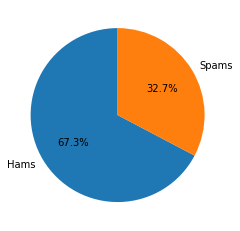

In [30]:
amount_of_spam=data['CATEGORY'].value_counts()[1]
amount_of_hams=data['CATEGORY'].value_counts()[0]
categories=['Hams','Spams']
sizes=[amount_of_hams,amount_of_spam]
plt.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=90)
plt.show()

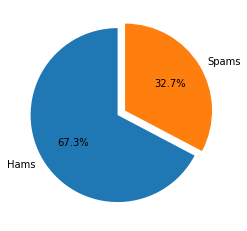

In [31]:
amount_of_spam=data['CATEGORY'].value_counts()[1]
amount_of_hams=data['CATEGORY'].value_counts()[0]
categories=['Hams','Spams']
sizes=[amount_of_hams,amount_of_spam]
plt.pie(sizes,labels=categories,autopct='%1.1f%%',explode=[0,0.1],startangle=90)
plt.show()

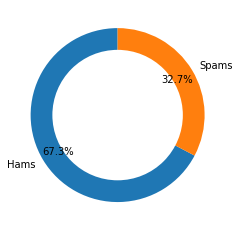

In [32]:
amount_of_spam=data['CATEGORY'].value_counts()[1]
amount_of_hams=data['CATEGORY'].value_counts()[0]
categories=['Hams','Spams']
sizes=[amount_of_hams,amount_of_spam]
center_cirle=plt.Circle((0,0),radius=0.75,fc='white')
plt.gca().add_artist(center_cirle)
plt.pie(sizes,labels=categories,autopct='%1.1f%%',startangle=90,pctdistance=0.8)
plt.show()

In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

## TOKENISING

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Ravikanth
[nltk_data]     Ch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
word_tokenize('Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.'.lower())

['natural',
 'language',
 'processing',
 '(',
 'nlp',
 ')',
 'is',
 'a',
 'subfield',
 'of',
 'linguistics',
 ',',
 'computer',
 'science',
 ',',
 'information',
 'engineering',
 ',',
 'and',
 'artificial',
 'intelligence',
 'concerned',
 'with',
 'the',
 'interactions',
 'between',
 'computers',
 'and',
 'human',
 '(',
 'natural',
 ')',
 'languages',
 ',',
 'in',
 'particular',
 'how',
 'to',
 'program',
 'computers',
 'to',
 'process',
 'and',
 'analyze',
 'large',
 'amounts',
 'of',
 'natural',
 'language',
 'data',
 '.']

## STOP WORDS

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ravikanth
[nltk_data]     Ch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop_words=set(stopwords.words('english'))

In [38]:
msg='All work and no play makes Jack  a dull boy. To be or not to be.'
words=word_tokenize(msg.lower())
stemmer=PorterStemmer()
filtered=[]
for i in words:
    if i not in stop_words:
        
        filtered.append(stemmer.stem(i))

In [39]:
filtered

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.']

## REMOVING HTML TAGS

In [40]:
from bs4 import BeautifulSoup

In [41]:
soup=BeautifulSoup(data['MESSAGE'][0],'html.parser')

In [42]:
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
 </body>
</html>
<tr>
 <td colspan="3D3">
  <hr color="3Dblack" noshade="" size="3D1"/>
 </td>
</tr>
<!-- End Calypso -->
<!-- Inserted by Calypso=

 -->
<font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
 <br/>
</font>
&lt;=

/TR&gt;
<!-- End Calypso -->
<font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
 <center>
  Save up to 70% on Life Insurance.
 </ce

In [43]:
print(soup.get_text())















<=

/TR>
Save up to 70% on Life Insurance.
Why Spend More Than You Have To?


Life Quote Savings











Ensurin=

g your 

      family's financial security is very important. Life Quote Savings ma=

kes 

      buying life insurance simple and affordable. We Provide FREE Access =

to The 

      Very Best Companies and The Lowest Rates.





Life Quote Savings is FAST, EAS=

Y and 

            SAVES you money! Let us help you get started with the best val=

ues in 

            the country on new coverage. You can SAVE hundreds or even tho=

usands 

            of dollars by requesting a FREE quote from Lifequote Savings. =

Our 

            service will take you less than 5 minutes to complete. Shop an=

d 

            compare. SAVE up to 70% on all types of Life insurance! 




Click Here For Your=

 

            Free Quote!

Protecting your family is the best investment you'll eve=

r 

          make!








If you are in receipt of this=

 email 

      in

## FUNCTIONS FOR EMAIL PROCESSING

In [44]:
def clean_message(message):
    words=word_tokenize(message.lower())
    filtered_words=[]
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [45]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [46]:
#cleaning messagewith no html tags
def clean_msg_no_html(message):
    soup=BeautifulSoup(message,'html.parser')
    cleaned_text=soup.get_text()
    words=word_tokenize(cleaned_text.lower())
    filtered_words=[]
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [47]:
clean_msg_no_html(data['MESSAGE'][0])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

In [48]:
nested_list=data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Ravikanth Ch\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [49]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [50]:
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676


In [51]:
doc_ids_spam=data[data['CATEGORY']==1].index

In [52]:
doc_ids_ham=data[data['CATEGORY']==0].index

In [53]:
nested_list_spam=nested_list.loc[doc_ids_spam]
nested_list_ham=nested_list.loc[doc_ids_ham]

In [54]:
nested_list_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [55]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [56]:
all_words_spam=[word for words in nested_list_spam for word in words ]

In [57]:
total_words_spam=len(all_words_spam)
total_words_spam

320571

In [58]:
all_words_ham=[word for words in nested_list_ham for word in words]

In [59]:
total_words_ham=len(all_words_ham)

In [60]:
from collections import Counter

In [61]:
top_10_spam_words=Counter(all_words_spam)

In [62]:
top_10_spam_words.most_common(10)

[('http', 3101),
 ('email', 3094),
 ('free', 2555),
 ('click', 2058),
 ('receiv', 1987),
 ('list', 1974),
 ('get', 1903),
 ('pleas', 1842),
 ('busi', 1792),
 ('order', 1743)]

In [63]:
top_10_ham_words=Counter(all_words_ham)
top_10_ham_words.most_common(10)

[('http', 7561),
 ('use', 3630),
 ('list', 2878),
 ('one', 2371),
 ('get', 2284),
 ('mail', 2255),
 ('would', 2003),
 ('like', 1928),
 ('messag', 1847),
 ('work', 1798)]

## CREATE A WORD CLOUD

In [64]:
from wordcloud import WordCloud

In [65]:
word_cloud=WordCloud().generate(email_body)

(-0.5, 399.5, 199.5, -0.5)

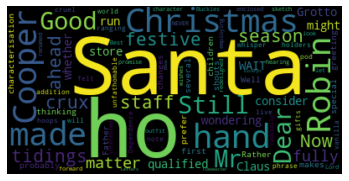

In [66]:
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')

In [67]:
nltk.download('shakespeare')
nltk.download('gutenberg')

[nltk_data] Downloading package shakespeare to C:\Users\Ravikanth
[nltk_data]     Ch\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package gutenberg to C:\Users\Ravikanth
[nltk_data]     Ch\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [68]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [69]:
len(example_corpus)

260819

In [70]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [71]:
word_list=[''.join(word) for word in example_corpus]
word_list

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [72]:
novel_as_string=' '.join(word_list)

In [73]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

(-0.5, 399.5, 199.5, -0.5)

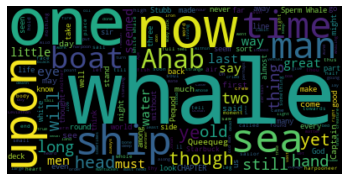

In [74]:
word_cloud=WordCloud().generate(novel_as_string)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')

In [75]:
from PIL import Image
import numpy as np

In [76]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

In [77]:
word_cloud=WordCloud(mask=rgb_array,max_words=450,background_color='white').generate(novel_as_string)

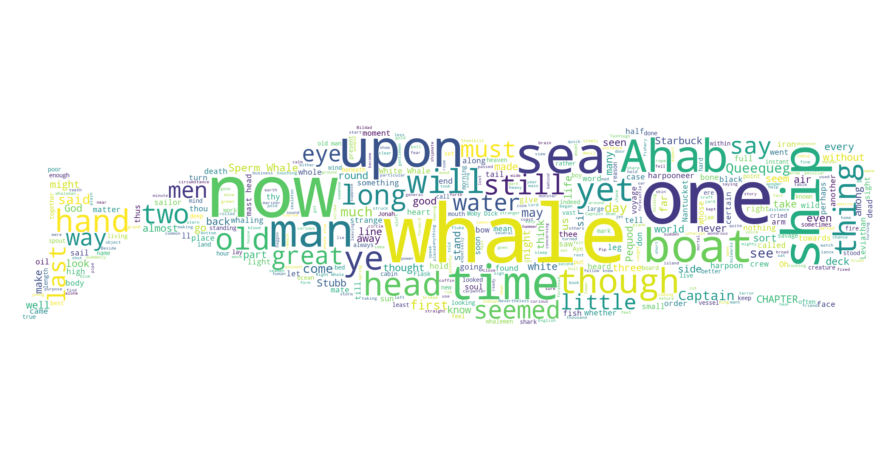

In [78]:
plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## WORD CLOUD FOR SHAKESPEARE'S HAMLET

In [79]:
HAMLET_FILE=nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

In [80]:
HAMLET_FILE=[''.join(word) for word in HAMLET_FILE]

In [81]:
HAMLET_FILE=' '.join(HAMLET_FILE)

In [82]:
HAMLET_FILE

"[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar

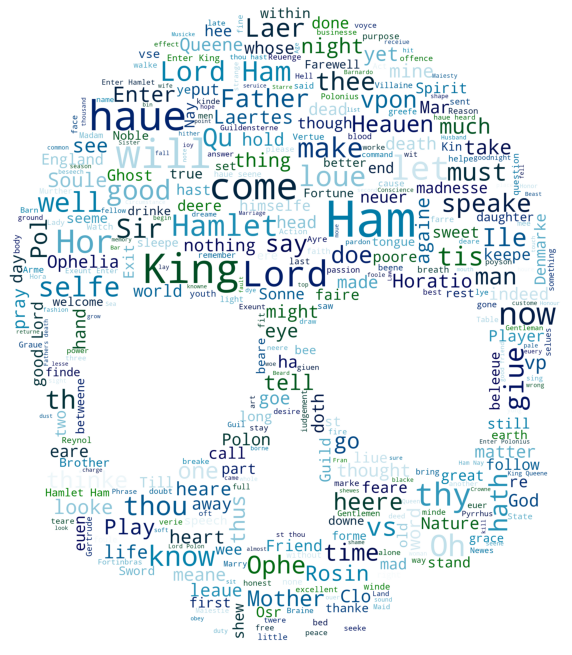

In [83]:
icon=Image.open(skull_icon)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
image_mask=np.array(image_mask)
plt.figure(figsize=(10,20))
word_cloud=WordCloud(mask=image_mask,max_words=400,background_color='white',colormap='ocean').generate(HAMLET_FILE)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## WORD CLOUDS FOR SPAM AND HAM EMAILS

In [84]:
ham_icon='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
spam_icon='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
font_path='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [85]:
cleaned_spam=' '.join(all_words_spam)

In [86]:
cleaned_ham=' '.join(all_words_ham)

In [87]:
spam_icon=Image.open(spam_icon)
ham_icon=Image.open(ham_icon)

In [88]:
spam_mask=Image.new(mode='RGB',color=(255,255,255),size=spam_icon.size)
ham_mask=Image.new(mode='RGB',color=(255,255,255),size=ham_icon.size)

In [89]:
spam_mask.paste(spam_icon,box=spam_icon)
ham_mask.paste(ham_icon,box=ham_icon)

In [90]:
spam_mask=np.array(spam_mask)
ham_mask=np.array(ham_mask)

In [91]:
spam_wordcloud=WordCloud(mask=spam_mask,background_color='white',max_words=2000,font_path=font_path,colormap='copper').generate(cleaned_spam.upper())
ham_wordcloud=WordCloud(mask=ham_mask,background_color='white',max_words=2000,font_path=font_path,colormap='copper').generate(cleaned_ham.upper())

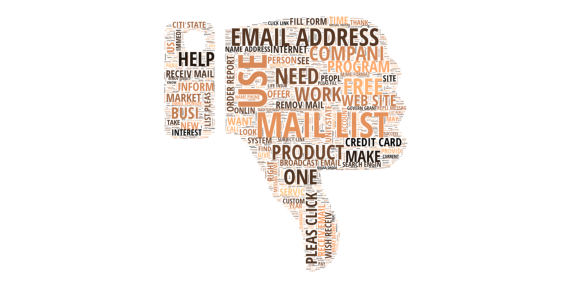

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.show()

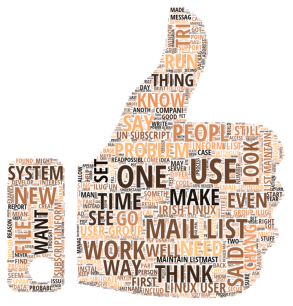

In [93]:
plt.figure(figsize=(5,20))
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.show()

In [94]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [95]:
unique_words=pd.Series([word for sublist in nested_list for word in sublist]).value_counts()

In [96]:
most_freq_words=unique_words[0:VOCAB_SIZE]

In [97]:
most_freq_words

http       10662
use         5017
list        4852
email       4370
get         4187
           ...  
invalid       44
bob           44
shoot         44
scope         44
trader        44
Length: 2500, dtype: int64

## CREATE VOCAB DATAFRAME WITH WORD_ID

In [98]:
vocab=pd.DataFrame({'VOCAB_WORD':most_freq_words.index.values})

In [99]:
vocab.head()

,VOCAB_WORD
0,http
1,use
2,list
3,email
4,get


## SPARSE MATRIX

In [100]:
np.argmax([len(i) for i in data.MESSAGE])

340

In [101]:
type(nested_list)

pandas.core.series.Series

In [102]:
word_column_df=pd.DataFrame.from_records(nested_list.tolist())

In [103]:
word_column_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [104]:
word_column_df.shape

(5796, 7671)

# SPLITTING INTO TRAIN AND TEST DATASETS

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train,X_test,y_train,y_test=train_test_split(word_column_df,data.CATEGORY,random_state=42,test_size=0.3)

In [107]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [108]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [109]:
X_train.index.name='DOC_ID'

In [110]:
X_test.index.name='DOC_ID'

In [111]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## SPARSE MATRIX FOR TRAIN DATA

In [112]:
word_index=pd.Index(vocab.VOCAB_WORD)

In [113]:
word_index.get_loc('http')

0

In [114]:
def make_sparse_matrix(df,indexed_words,labels):
    nr_rows=df.shape[0]
    nr_columns=df.shape[1]
    word_set=set(indexed_words)
    dict_list=[]
    for i in range(nr_rows):
        for j in range(nr_columns):
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                item={'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)                    

In [115]:
sparse_trained_df=make_sparse_matrix(X_train,word_index,y_train)

In [116]:
sparse_trained_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1257
2,0,4844,1,508
3,0,4844,1,310
4,0,4844,1,255
...,...,...,...,...
430961,1,860,1,47
430962,1,860,1,1434
430963,1,860,1,26
430964,1,860,1,19


In [117]:
trained_grouped=sparse_trained_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [118]:
trained_grouped=trained_grouped.reset_index()

In [119]:
trained_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [120]:
trained_grouped.loc[trained_grouped['DOC_ID']==5]

,DOC_ID,WORD_ID,LABEL,OCCURENCE
271,5,2,1,1
272,5,3,1,3
273,5,4,1,2
274,5,5,1,1
275,5,6,1,2
...,...,...,...,...
377,5,1992,1,1
378,5,2059,1,1
379,5,2065,1,1
380,5,2289,1,1


In [121]:
vocab['VOCAB_WORD'].at[1900]

'odd'

In [122]:
sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)

In [123]:
test_grouped=sparse_test_df.groupby(['DOC_ID',"WORD_ID",'LABEL']).sum()

In [124]:
test_grouped=test_grouped.reset_index()

In [125]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


## SAVING TRAIN AND TEST TXT FILES

In [126]:
np.savetxt(TRAINING_DATA_FILE,trained_grouped,fmt='%d')
np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')